### Check LLVM version

In [33]:
import llvmlite
print("llvmlite version:", llvmlite.__version__)

from llvmlite.binding.initfini import llvm_version_info
print("llvm version:", '.'.join(map(str, llvm_version_info)))

llvmlite version: 0.44.0dev0+146.g75f6e31
llvm version: 20.0.0


### Example to show the perf benifits of Numba

In [34]:
import numpy as np
from numba import jit

arr = np.random.randn(100000)

@jit
def get_sum_jit(arr):
    s = 0.0
    for x in arr:
        s += x
    return s

def get_sum_no_jit(arr):
    s = 0.0
    for x in arr:
        s += x
    return s

%timeit get_sum_jit(arr) 
%timeit get_sum_no_jit(arr)

60.3 μs ± 79.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
5.13 ms ± 27.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Part 1: IR Builder
### How to use llvmlite's IRBuilder APIs to build your own llvm based compiler

#### Example 1: Building a simple llvm function to add 2 32bit integers

In [35]:
# Import the IR layer
from llvmlite import ir

In [36]:
# Create a module for our function
mod = ir.Module(name='')
print(mod)

; ModuleID = ""
target triple = "unknown-unknown-unknown"
target datalayout = ""



In [37]:
# Build signature of our function
foo_type = ir.FunctionType(ir.IntType(32), [ir.IntType(32), ir.IntType(32)])
foo = ir.Function(mod, foo_type, "add2")
print(foo)

declare i32 @"add2"(i32 %".1", i32 %".2")



In [38]:
# Add a basic block
foo.append_basic_block(name="entry")
print(foo)

define i32 @"add2"(i32 %".1", i32 %".2")
{
entry:
}



In [39]:
# IRBuidler is the builder class for generating llvm ir in llvmlite

builder = ir.IRBuilder(foo.entry_basic_block)
print(builder.block)
print("*" * 20)
print(builder.function)
print("*" * 20)
print(builder.module)

%"entry" = entry:
********************
define i32 @"add2"(i32 %".1", i32 %".2")
{
entry:
}

********************
; ModuleID = ""
target triple = "unknown-unknown-unknown"
target datalayout = ""

define i32 @"add2"(i32 %".1", i32 %".2")
{
entry:
}



In [40]:
# Capture the function args in 'a' and 'b'
a, b = builder.function.args[:2]
print("Function args are:", a, b)

# Add an 'add' instruction
c = builder.add(a, b, 'c')

# Add the 'ret' instruction
builder.ret(c)

print(foo)

Function args are: i32 %".1" i32 %".2"
define i32 @"add2"(i32 %".1", i32 %".2")
{
entry:
  %"c" = add i32 %".1", %".2"
  ret i32 %"c"
}



In [41]:
print(mod)

; ModuleID = ""
target triple = "unknown-unknown-unknown"
target datalayout = ""

define i32 @"add2"(i32 %".1", i32 %".2")
{
entry:
  %"c" = add i32 %".1", %".2"
  ret i32 %"c"
}



Lets fix the target triple and module name

In [42]:
builder.module.name = "test_module"
builder.module.triple = "aarch64-unknown-linux"
print(mod)



; ModuleID = "test_module"
target triple = "aarch64-unknown-linux"
target datalayout = ""

define i32 @"add2"(i32 %".1", i32 %".2")
{
entry:
  %"c" = add i32 %".1", %".2"
  ret i32 %"c"
}



We can even add function attributes

In [43]:
builder.function.attributes.add("noinline")

print(mod)

; ModuleID = "test_module"
target triple = "aarch64-unknown-linux"
target datalayout = ""

define i32 @"add2"(i32 %".1", i32 %".2") noinline
{
entry:
  %"c" = add i32 %".1", %".2"
  ret i32 %"c"
}



#### Example 2: Lets try adding another function to this module

Add another function called add3 to the moudle which take 3 integers as arguments and returns their sum

In [44]:
int32 = ir.IntType(32)
fnty = ir.FunctionType(int32, (int32, int32, int32))

# Adding the new function to module 'mod'
bar = ir.Function(mod, fnty, "add3")
print(bar)

declare i32 @"add3"(i32 %".1", i32 %".2", i32 %".3")



In [45]:
print(mod)

; ModuleID = "test_module"
target triple = "aarch64-unknown-linux"
target datalayout = ""

define i32 @"add2"(i32 %".1", i32 %".2") noinline
{
entry:
  %"c" = add i32 %".1", %".2"
  ret i32 %"c"
}

declare i32 @"add3"(i32 %".1", i32 %".2", i32 %".3")



In [46]:
bar.append_basic_block(name="entry")
print(bar)

define i32 @"add3"(i32 %".1", i32 %".2", i32 %".3")
{
entry:
}



In [47]:
builder_bar = ir.IRBuilder(bar.entry_basic_block)

In [48]:
print(builder_bar.block)
print("*" * 20)
print(builder_bar.function)
print("*" * 20)
print(builder_bar.module)

%"entry" = entry:
********************
define i32 @"add3"(i32 %".1", i32 %".2", i32 %".3")
{
entry:
}

********************
; ModuleID = "test_module"
target triple = "aarch64-unknown-linux"
target datalayout = ""

define i32 @"add2"(i32 %".1", i32 %".2") noinline
{
entry:
  %"c" = add i32 %".1", %".2"
  ret i32 %"c"
}

define i32 @"add3"(i32 %".1", i32 %".2", i32 %".3")
{
entry:
}



In [49]:
# Capture the args in 'a', 'b' and 'c'
a, b, c = builder_bar.function.args[:3]
print("Function args are:", a, b, c)

# Add the 'add' instructions
sum1 = builder_bar.add(a, b, 'sum1')
sum2 = builder_bar.add(c, sum1, 'sum2')

# Add the 'ret' instruction
builder_bar.ret(sum2)
print(bar)

Function args are: i32 %".1" i32 %".2" i32 %".3"
define i32 @"add3"(i32 %".1", i32 %".2", i32 %".3")
{
entry:
  %"sum1" = add i32 %".1", %".2"
  %"sum2" = add i32 %".3", %"sum1"
  ret i32 %"sum2"
}



In [50]:
print(mod)

; ModuleID = "test_module"
target triple = "aarch64-unknown-linux"
target datalayout = ""

define i32 @"add2"(i32 %".1", i32 %".2") noinline
{
entry:
  %"c" = add i32 %".1", %".2"
  ret i32 %"c"
}

define i32 @"add3"(i32 %".1", i32 %".2", i32 %".3")
{
entry:
  %"sum1" = add i32 %".1", %".2"
  %"sum2" = add i32 %".3", %"sum1"
  ret i32 %"sum2"
}



We could also create functions in different modules and link them into a single module

In [51]:
# import llvmlite.binding as llvm

# IRModule = llvm.parse_assembly(str(mod))
# IRModule.link_in(llvm.parse_assembly(str(mod_bar)))
# IRModule.name = mod.name

#### TODO: A More complex example with 'phi' nodes/ 'loops' etc

# Part 2: LLVM Playground
### How to leverage llvmlite to hack around with LLVM-IR using python

In [52]:
# Intitialzations
import llvmlite.binding as llvm

llvm.initialize_native_target()
llvm.initialize_native_asmprinter()

In [53]:
# Helper function to create a TargetMachine object
def target_machine(jit):
    target = llvm.Target.from_default_triple()
    return target.create_target_machine(jit=jit)


In [54]:
# Helper function to create a PassBuilder object
def pass_builder(speed_level=0, size_level=0):
    tm = target_machine(jit=False)
    pto = llvm.create_pipeline_tuning_options(speed_level, size_level)
    pb = llvm.create_pass_builder(tm, pto)
    return pb


In [55]:
# Helper function to create PassManager object
def mpm():
    return llvm.create_new_module_pass_manager()


#### Example 1: Lets try running a llvm pass (simplifycfg) on a llvm ir string

In [56]:
# Below function takes a pointer to an array and return the number of 0s in first 10 elements
ir = r"""
define i32 @count_zeroes(i32* noalias nocapture readonly %src) {
entry:
  br label %loop.header

loop.header:
  %iv = phi i64 [ 0, %entry ], [ %inc, %loop.latch ]
  %r1  = phi i32 [ 0, %entry ], [ %r3, %loop.latch ]
  %arrayidx = getelementptr inbounds i32, i32* %src, i64 %iv
  %src_element = load i32, i32* %arrayidx, align 4
  %cmp = icmp eq i32 0, %src_element
  br i1 %cmp, label %loop.if, label %loop.latch

loop.if:
  %r2 = add i32 %r1, 1
  br label %loop.latch
loop.latch:
  %r3 = phi i32 [%r1, %loop.header], [%r2, %loop.if]
  %inc = add nuw nsw i64 %iv, 1
  %exitcond = icmp eq i64 %inc, 9
  br i1 %exitcond, label %loop.end, label %loop.header
loop.end:
  %r.lcssa = phi i32 [ %r3, %loop.latch ]
  ret i32 %r.lcssa
}
"""

# Parse the IR as a string to module object
count_zeroes_mod = llvm.parse_assembly(ir)


In [57]:
# Let's run simplify-cfg pass on this module
pm = mpm()
pb = pass_builder()
pm.add_simplify_cfg_pass()
pm.run(count_zeroes_mod, pb)

print(count_zeroes_mod)


; ModuleID = '<string>'
source_filename = "<string>"

define i32 @count_zeroes(ptr noalias nocapture readonly %src) {
entry:
  br label %loop.header

loop.header:                                      ; preds = %loop.header, %entry
  %iv = phi i64 [ 0, %entry ], [ %inc, %loop.header ]
  %r1 = phi i32 [ 0, %entry ], [ %spec.select, %loop.header ]
  %arrayidx = getelementptr inbounds i32, ptr %src, i64 %iv
  %src_element = load i32, ptr %arrayidx, align 4
  %cmp = icmp eq i32 0, %src_element
  %r2 = add i32 %r1, 1
  %spec.select = select i1 %cmp, i32 %r2, i32 %r1
  %inc = add nuw nsw i64 %iv, 1
  %exitcond = icmp eq i64 %inc, 9
  br i1 %exitcond, label %loop.end, label %loop.header

loop.end:                                         ; preds = %loop.header
  %r.lcssa = phi i32 [ %spec.select, %loop.header ]
  ret i32 %r.lcssa
}





### What else can we do?

How about running the default llvm optimization pipelines (O0..On, etc)


#### Example2: Run O3 pipeline on given LLVM IR

In [58]:
# Given function takes 2 values as args and return their sum
addFunc = r"""
define noundef i32 @add2nums(i32 noundef %0, i32 noundef %1) {
  %3 = alloca i32, align 4
  %4 = alloca i32, align 4
  store i32 %0, i32* %3, align 4
  store i32 %1, i32* %4, align 4
  %5 = load i32, i32* %3, align 4
  %6 = load i32, i32* %4, align 4
  %7 = add nsw i32 %5, %6
  ret i32 %7
}
"""

# Initialize and parse the llvm module from a python string
mod = llvm.parse_assembly(addFunc)

# Initialize pass builder with speed_level=3, i.e -O3
pb = pass_builder(speed_level=3)

# Get appropriate pass manager for this speed level and optimise the module
pm = pb.getModulePassManager()
pm.run(mod, pb)
print(mod)


; ModuleID = '<string>'
source_filename = "<string>"

; Function Attrs: mustprogress nofree norecurse nosync nounwind willreturn memory(none)
define noundef i32 @add2nums(i32 noundef %0, i32 noundef %1) local_unnamed_addr #0 {
  %3 = add nsw i32 %1, %0
  ret i32 %3
}

attributes #0 = { mustprogress nofree norecurse nosync nounwind willreturn memory(none) }



#### Example3: Run O0 optimization pipeline on given LLVM IR?

In [59]:
mod = llvm.parse_assembly(addFunc)

# Initialize pass builder with speed_level=0, i.e -O0
pb = pass_builder(speed_level=0)

# Get appropriate pass manager for this speed level and optimise the module
pm = pb.getModulePassManager()
pm.run(mod, pb)
print(mod)

; ModuleID = '<string>'
source_filename = "<string>"

define noundef i32 @add2nums(i32 noundef %0, i32 noundef %1) {
  %3 = alloca i32, align 4
  %4 = alloca i32, align 4
  store i32 %0, ptr %3, align 4
  store i32 %1, ptr %4, align 4
  %5 = load i32, ptr %3, align 4
  %6 = load i32, ptr %4, align 4
  %7 = add nsw i32 %5, %6
  ret i32 %7
}



### Create custom pipelines?

#### Example3: Create and execute custom optimisation pipeline

In [60]:
asm_inlineasm2 = r"""
    define i32 @caller(i32 %.1, i32 %.2) {
    entry:
      %stack = alloca i32
      store i32 %.1, i32* %stack
      br label %main
    main:
      %loaded = load i32, i32* %stack
      %.3 = add i32 %loaded, %.2
      %.4 = add i32 0, %.3
      ret i32 %.4
    }
"""

mod = llvm.parse_assembly(asm_inlineasm2)

# Below lines might error out since name of these APIs are now changed under NewPassManager chages in llvmlite

pm = mpm()
pm.add_constant_merge_pass()
pm.add_dead_arg_elimination_pass()
pm.add_post_order_function_attributes_pass()
# pm.add_function_inlining_pass(225)
pm.add_global_dead_code_eliminate_pass()
pm.add_global_opt_pass()
pm.add_ipsccp_pass()
pm.add_dead_code_elimination_pass()
pm.add_simplify_cfg_pass()
pm.add_new_gvn_pass()
pm.add_instruction_combine_pass()
# pm.add_licm_pass()
pm.add_sccp_pass()
# pm.add_sroa_pass()
# pm.add_type_based_alias_analysis_pass()
# pm.add_basic_alias_analysis_pass()
# pm.add_loop_rotate_pass()
# pm.add_region_info_pass()
# pm.add_scalar_evolution_aa_pass()
# pm.add_aggressive_dead_code_elimination_pass()
# pm.add_aa_eval_pass()
# pm.add_always_inliner_pass()
# pm.add_break_critical_edges_pass()
# pm.add_dead_store_elimination_pass()
# pm.add_reverse_post_order_function_attrs_pass()
pm.run(mod, pass_builder())
print(mod)

; ModuleID = '<string>'
source_filename = "<string>"

; Function Attrs: mustprogress nofree norecurse nosync nounwind willreturn memory(none)
define i32 @caller(i32 %.1, i32 %.2) local_unnamed_addr #0 {
entry:
  %.3 = add i32 %.1, %.2
  ret i32 %.3
}

attributes #0 = { mustprogress nofree norecurse nosync nounwind willreturn memory(none) }



### We can also access LLVM's plethora of visulization passes

#### Example4: Python function to generate CFG graph of an LLVM IR

In [61]:
# Helper function to render LLVM IR as a dot graph

def renderModuleAsDotGraph(mod, func_name):
  pm = mpm()
  pm.add_cfg_printer_pass()
  pm.run(mod, pass_builder())   # dot graph written to ".func_name.dot"
  !dot -Tpng .{func_name}.dot > {func_name}.png


Writing '.count_zeroes.dot'...


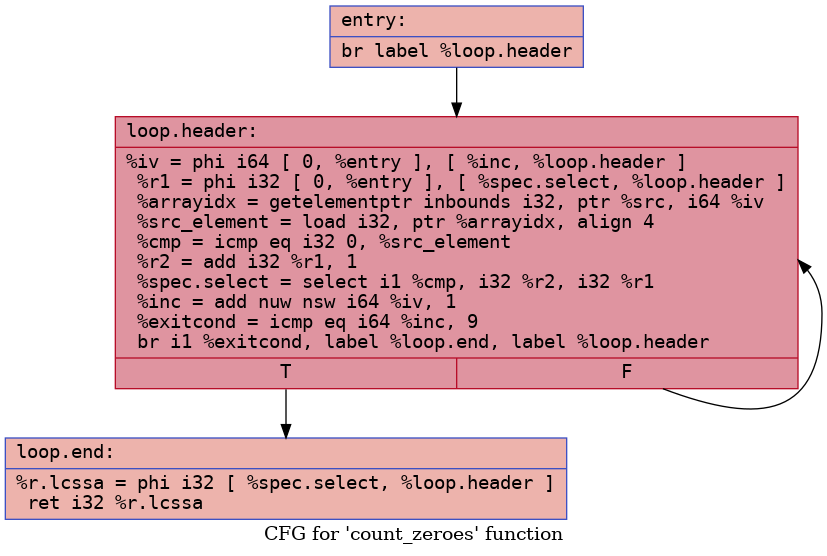

In [62]:
from IPython.display import Image
renderModuleAsDotGraph(count_zeroes_mod, "count_zeroes")
Image('count_zeroes.png')


### More single pass pipelines for experimentation?

1.   Dominator tree
2.   Post dominator tree
3.   SLP Vectorizer



Writing 'dom.count_zeroes.dot'...


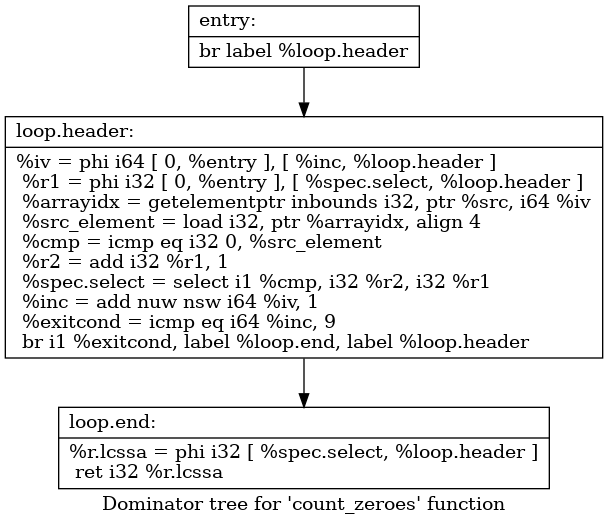

In [63]:
# Function to generate dominator tree of a LLVM function

def generateDom(mod, func_name):
  pm = mpm()
  pm.add_dom_printer_pass()
  pm.run(mod, pass_builder())   # dot graph written to ".func_name.dot"
  !dot -Tpng dom.{func_name}.dot > {func_name}.png

generateDom(count_zeroes_mod, "count_zeroes")
Image('count_zeroes.png')


Writing 'postdom.count_zeroes.dot'...


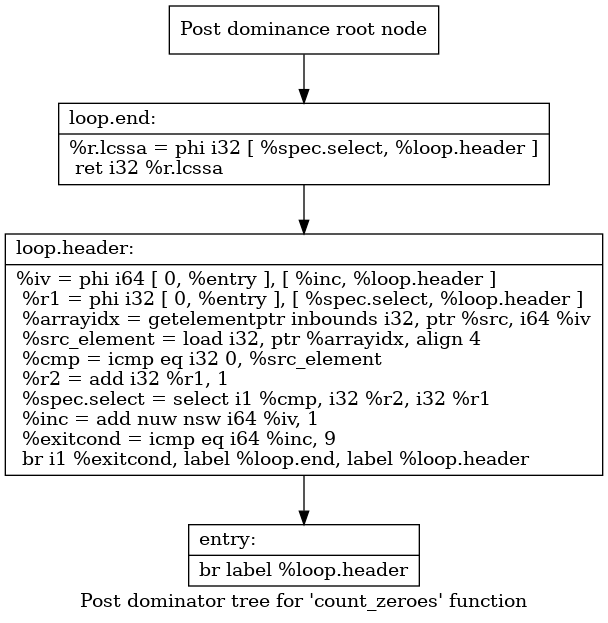

In [64]:
# Function to generate post dominator tree of a LLVM function

def generatePostDom(mod, func_name):
  pm = mpm()
  pm.add_post_dom_printer_pass()
  pm.run(mod, pass_builder())   # dot graph written to ".func_name.dot"
  !dot -Tpng postdom.{func_name}.dot > {func_name}.png

generatePostDom(count_zeroes_mod, "count_zeroes")
Image('count_zeroes.png')


In [65]:
ir = r"""
define i32 @foo(i32* noalias nocapture readonly %src) {
entry:
  br label %loop.header

loop.header:
  %iv = phi i64 [ 0, %entry ], [ %inc, %loop.latch ]
  %r1  = phi i32 [ 0, %entry ], [ %r3, %loop.latch ]
  %arrayidx = getelementptr inbounds i32, i32* %src, i64 %iv
  %src_element = load i32, i32* %arrayidx, align 4
  %cmp = icmp eq i32 0, %src_element
  br i1 %cmp, label %loop.if, label %loop.latch

loop.if:
  %r2 = add i32 %r1, 1
  br label %loop.latch
loop.latch:
  %r3 = phi i32 [%r1, %loop.header], [%r2, %loop.if]
  %inc = add nuw nsw i64 %iv, 1
  %exitcond = icmp eq i64 %inc, 9
  br i1 %exitcond, label %loop.end, label %loop.header
loop.end:
  %r.lcssa = phi i32 [ %r3, %loop.latch ]
  ret i32 %r.lcssa
}
"""

mod = llvm.parse_assembly(ir)

Experiement with slp_vectorizer?

In [66]:
ir = r"""
define i32 @foo() {
entry:
  %i = xor i32 4, -9
  %i1 = xor i32 5, %i
  %i2 = xor i32 6, %i1
  %i3 = add i32 %i2, 0
  %i4 = add i32 -9, %i3
  %i5 = xor i32 8, -9
  %i6 = add i32 %i5, %i4
  %i7 = xor i32 9, %i5
  %i8 = add i32 %i7, %i6
  %i9 = xor i32 10, %i7
  %i10 = add i32 %i9, %i8
  %i11 = add i32 -9, %i10
  %i12 = xor i32 12, -9
  %i13 = add i32 %i12, %i11
  %i14 = xor i32 13, %i12
  %i15 = add i32 %i14, %i13
  %i16 = xor i32 14, %i14
  %i17 = add i32 %i16, %i15
  %i18 = add i32 -9, %i17
  %i19 = xor i32 16, -9
  %i20 = add i32 %i19, %i18
  %i21 = xor i32 17, %i19
  %i22 = add i32 %i21, %i20
  %i23 = xor i32 18, %i21
  %i24 = add i32 %i23, %i22
  %i25 = add i32 -9, %i24
  %i26 = add i32 0, %i25
  %i27 = add i32 0, %i26
  %i28 = add i32 0, %i27
  %i29 = add i32 -9, %i28
  %i30 = add i32 0, %i29
  %i31 = add i32 0, %i30
  %i32 = add i32 0, %i31
  ret i32 %i32
}
"""

pm = mpm()
pm.add_slp_vectorizer_pass()
pm.add_instruction_combining_pass()

# Somebody gonna have to add the python hook for slp_vectorizer


AttributeError: 'ModulePassManager' object has no attribute 'add_slp_vectorizer_pass'

### How about code generation?

In [67]:
import llvmlite.binding as llvm

llvm.initialize_native_target()

target = llvm.Target.from_default_triple()
tm = target.create_target_machine()

In [68]:
print(target)
print(tm.triple)
print(tm.target_data)

<Target aarch64 (AArch64 (little endian))>
aarch64-unknown-linux-gnu
e-m:e-p270:32:32-p271:32:32-p272:64:64-i8:8:32-i16:16:32-i64:64-i128:128-n32:64-S128-Fn32


You are not limited to native target

In [69]:
llvm.initialize_all_targets()
#llvm.initialize_native_target()

llvm.initialize_all_asmprinters()
# llvm.initialize_native_asmprinter()



In [73]:

# target_riscv = llvm.Target.from_triple("riscv32-unknown-linux")
# riscv_tm = target_riscv.create_target_machine()

# target_x86 = llvm.Target.from_triple("x86-unknown-linux")
# x86_tm = target_aarch64.create_target_machine()

native_tm = llvm.Target.from_default_triple().create_target_machine()



Lets look at the assebmly of our optimized IR for different targets

In [74]:
llvm.initialize_all_asmprinters()
# llvm.initialize_native_asmprinter()

ir = """
define dso_local noundef i32 @add(i32 noundef %0, i32 noundef %1) #0 {
  %3 = alloca i32, align 4
  %4 = alloca i32, align 4
  store i32 %0, i32* %3, align 4
  store i32 %1, i32* %4, align 4
  %5 = load i32, i32* %3, align 4
  %6 = load i32, i32* %4, align 4
  %7 = add nsw i32 %5, %6
  ret i32 %7
}
"""
mod = llvm.parse_assembly(ir)

print("*" * 40, "Native asm")
print(native_tm.emit_assembly(mod))
# print("*" * 40, "RISCV asm")
# print(riscv_tm.emit_assembly(mod))
# print("*" * 40, "x86 asm")
# print(aarch64_tm.emit_assembly(mod))


**************************************** Native asm
	.file	"<string>"
	.text
	.globl	add
	.p2align	2
	.type	add,@function
add:
	.cfi_startproc
	sub	sp, sp, #16
	.cfi_def_cfa_offset 16
	stp	w1, w0, [sp, #8]
	add	w0, w0, w1
	add	sp, sp, #16
	ret
.Lfunc_end0:
	.size	add, .Lfunc_end0-add
	.cfi_endproc

	.section	".note.GNU-stack","",@progbits



Object code?

In [75]:
code_object_native = tm.emit_object(mod)
code_object_aarch64 = aarch64_tm.emit_object(mod)
print(code_object_native)



b'\x7fELF\x02\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\xb7\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x00\x00\x00\x00\x00@\x00\x07\x00\x01\x00\xffC\x00\xd1\xe1\x03\x01)\x00\x00\x01\x0b\xffC\x00\x91\xc0\x03_\xd6\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x00\x01zR\x00\x01|\x1e\x01\x1c\x0c\x1f\x00\x18\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00D\x0e\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x00\x00\x00\x04\x00\xf1\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00-\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00)\x00\x00\x00\x12\x

# 

# Part 3: Using the LLVM's jit compiler to execute the LLVM IR

Lets execute the @add2 and @add3 function we created in first half of our tutorial

In [76]:
# Initializations

import llvmlite.binding as llvm

llvm.initialize_native_target()
llvm.initialize_native_asmprinter()

Do any IR optimizations if any

#### Example 1: Let's execute the add2 function we created earlier

In [77]:
from ctypes import CFUNCTYPE, c_int, POINTER
import llvmlite.binding as llvm

ir = """
; ModuleID = "add_module"
target triple = "aarch64-unknown-linux"
target datalayout = ""

define i32 @"add2"(i32 %".1", i32 %".2") noinline
{
entry:
  %"c" = add i32 %".1", %".2"
  ret i32 %"c"
}
"""
llmod = llvm.parse_assembly(ir)
tm = target_machine(False)
compiler = llvm.create_mcjit_compiler(llmod, tm)
compiler.finalize_object()


Create the execution engine

In [78]:
cfptr_add2 = compiler.get_function_address("add2")
cfunc_add2 = CFUNCTYPE(c_int, c_int)(cfptr_add2)

In [79]:
print(cfunc_add2(-1, 2))
print(cfunc_add2(1, 2))


1
3


We are gonna call our functions using pointers to these functions

### A more complex example, sum of all elements in an array


In [82]:
import llvmlite.binding as llvm
import numpy as np

llvm.initialize_native_target()
llvm.initialize_native_asmprinter()

In [84]:
ir = """
; ModuleID = '<string>'
source_filename = "<string>"
target triple = "unknown-unknown-unknown"

define i32 @sum(i32* %.1, i32 %.2) {
.4:
  br label %.5

.5:                                               ; preds = %.5, %.4
  %.8 = phi i32 [ 0, %.4 ], [ %.13, %.5 ]
  %.9 = phi i32 [ 0, %.4 ], [ %.12, %.5 ]
  %.10 = getelementptr i32, i32* %.1, i32 %.8
  %.11 = load i32, i32* %.10, align 4
  %.12 = add i32 %.9, %.11
  %.13 = add i32 %.8, 1
  %.14 = icmp ult i32 %.13, %.2
  br i1 %.14, label %.5, label %.6

.6:                                               ; preds = %.5
  ret i32 %.12
}
"""

# Let's optimize the module first

mod = llvm.parse_assembly(ir)
pb = pass_builder(speed_level=3)

# Get appropriate pass manager for this speed level and optimise the module
pm = pb.getModulePassManager()
pm.run(mod, pb)
print(mod)


; ModuleID = '<string>'
source_filename = "<string>"
target triple = "unknown-unknown-unknown"

; Function Attrs: nofree norecurse nosync nounwind memory(argmem: read)
define i32 @sum(ptr nocapture readonly %.1, i32 %.2) local_unnamed_addr #0 {
.4:
  %0 = add i32 %.2, 2147483647
  %or.cond = icmp ult i32 %0, -2147483641
  br i1 %or.cond, label %.5.preheader, label %vector.ph

vector.ph:                                        ; preds = %.4
  %n.vec = and i32 %.2, -8
  br label %vector.body

vector.body:                                      ; preds = %vector.body, %vector.ph
  %index = phi i32 [ 0, %vector.ph ], [ %index.next, %vector.body ]
  %vec.phi = phi <4 x i32> [ zeroinitializer, %vector.ph ], [ %4, %vector.body ]
  %vec.phi2 = phi <4 x i32> [ zeroinitializer, %vector.ph ], [ %5, %vector.body ]
  %1 = sext i32 %index to i64
  %2 = getelementptr i32, ptr %.1, i64 %1
  %3 = getelementptr i8, ptr %2, i64 16
  %wide.load = load <4 x i32>, ptr %2, align 4
  %wide.load3 = load <4 x i32>

In [85]:
from ctypes import CFUNCTYPE, c_int, POINTER

tm = target_machine(True)
compiler = llvm.create_mcjit_compiler(mod, tm)

compiler.finalize_object()
cfptr = compiler.get_function_address("sum")

cfunc = CFUNCTYPE(c_int, POINTER(c_int), c_int)(cfptr)



In [86]:
tm.emit_assembly(mod)

'\t.file\t"<string>"\n\t.text\n\t.globl\tsum\n\t.p2align\t2\n\t.type\tsum,@function\nsum:\n\tmov\tw8, #2147483647\n\tmov\tw9, #-2147483641\n\tadd\tw8, w1, w8\n\tcmp\tw8, w9\n\tb.hs\t.LBB0_2\n\tmov\tw9, wzr\n\tmov\tw8, wzr\n\tb\t.LBB0_5\n.LBB0_2:\n\tmovi\tv0.2d, #0000000000000000\n\tmovi\tv1.2d, #0000000000000000\n\tand\tw9, w1, #0xfffffff8\n\tadd\tx8, x0, #16\n\tneg\tw10, w9\n.LBB0_3:\n\tldp\tq2, q3, [x8, #-16]\n\tadds\tw10, w10, #8\n\tadd\tx8, x8, #32\n\tadd\tv0.4s, v2.4s, v0.4s\n\tadd\tv1.4s, v3.4s, v1.4s\n\tb.ne\t.LBB0_3\n\tadd\tv0.4s, v1.4s, v0.4s\n\tcmp\tw1, w9\n\taddv\ts0, v0.4s\n\tfmov\tw8, s0\n\tb.eq\t.LBB0_6\n.LBB0_5:\n\tldr\tw10, [x0, w9, sxtw #2]\n\tadd\tw9, w9, #1\n\tcmp\tw9, w1\n\tadd\tw8, w10, w8\n\tb.lo\t.LBB0_5\n.LBB0_6:\n\tmov\tw0, w8\n\tret\n.Lfunc_end0:\n\t.size\tsum, .Lfunc_end0-sum\n\n\t.section\t".note.GNU-stack","",@progbits\n'

In [87]:
A = np.arange(10, dtype=np.int32)
res = cfunc(A.ctypes.data_as(POINTER(c_int)), A.size)


B = [1, 2, 3]
arr = (c_int * len(B))(*B)
res = cfunc(arr, len(B))

print(A)
print(res, A.sum())

print(B)
print(res, sum(B))


[0 1 2 3 4 5 6 7 8 9]
6 45
[1, 2, 3]
6 6


### Custom target machines

In [97]:
target = llvm.Target.from_triple("aarch64-unknown-linux")


In [98]:
tm_default_aarch64 = target.create_target_machine(cpu='', features='',
                              opt=2, reloc='default', codemodel='jitdefault',
                              printmc=False, jit=False, abiname='')


In [104]:
tm_neoverse_v2 = tm = target.create_target_machine(cpu='neoverse-v2', features='',
                              opt=2, reloc='default', codemodel='jitdefault',
                              printmc=False, jit=False, abiname='')


In [110]:
tm_features = tm = target.create_target_machine(cpu='', features='+crc,+crypto,\
                                +fp-armv8,+lse,+neon,+sve,+sve2',
                              opt=2, reloc='default', codemodel='jitdefault',
                              printmc=False, jit=False, abiname='')


'                                +fp-armv8' is not a recognized feature for this target (ignoring feature)


In [100]:
ir = """
; ModuleID = '<string>'
source_filename = "<string>"
target triple = "unknown-unknown-unknown"

define i32 @sum(i32* %.1, i32 %.2) {
.4:
  br label %.5

.5:                                               ; preds = %.5, %.4
  %.8 = phi i32 [ 0, %.4 ], [ %.13, %.5 ]
  %.9 = phi i32 [ 0, %.4 ], [ %.12, %.5 ]
  %.10 = getelementptr i32, i32* %.1, i32 %.8
  %.11 = load i32, i32* %.10, align 4
  %.12 = add i32 %.9, %.11
  %.13 = add i32 %.8, 1
  %.14 = icmp ult i32 %.13, %.2
  br i1 %.14, label %.5, label %.6

.6:                                               ; preds = %.5
  ret i32 %.12
}
"""

# Let's optimize the module first

mod = llvm.parse_assembly(ir)
pb = pass_builder(speed_level=3)

# Get appropriate pass manager for this speed level and optimise the module
pm = pb.getModulePassManager()
pm.run(mod, pb)

In [105]:
print(tm_default_aarch64.emit_assembly(mod))

	.file	"<string>"
	.text
	.globl	sum
	.p2align	2
	.type	sum,@function
sum:
	mov	w8, #2147483647
	mov	w9, #-2147483641
	add	w8, w1, w8
	cmp	w8, w9
	b.hs	.LBB0_2
	mov	w9, wzr
	mov	w8, wzr
	b	.LBB0_5
.LBB0_2:
	movi	v0.2d, #0000000000000000
	movi	v1.2d, #0000000000000000
	and	w9, w1, #0xfffffff8
	add	x8, x0, #16
	neg	w10, w9
.LBB0_3:
	ldp	q2, q3, [x8, #-16]
	adds	w10, w10, #8
	add	x8, x8, #32
	add	v0.4s, v2.4s, v0.4s
	add	v1.4s, v3.4s, v1.4s
	b.ne	.LBB0_3
	add	v0.4s, v1.4s, v0.4s
	cmp	w1, w9
	addv	s0, v0.4s
	fmov	w8, s0
	b.eq	.LBB0_6
.LBB0_5:
	ldr	w10, [x0, w9, sxtw #2]
	add	w9, w9, #1
	cmp	w9, w1
	add	w8, w10, w8
	b.lo	.LBB0_5
.LBB0_6:
	mov	w0, w8
	ret
.Lfunc_end0:
	.size	sum, .Lfunc_end0-sum

	.section	".note.GNU-stack","",@progbits



In [106]:
print(tm_neoverse_v2.emit_assembly(mod))

	.file	"<string>"
	.text
	.globl	sum
	.p2align	4
	.type	sum,@function
sum:
	mov	w8, #2147483647
	mov	w9, #-2147483641
	add	w8, w1, w8
	cmp	w8, w9
	b.hs	.LBB0_2
	mov	w9, wzr
	mov	w8, wzr
	b	.LBB0_5
.LBB0_2:
	and	w9, w1, #0xfffffff8
	add	x8, x0, #16
	movi	v0.2d, #0000000000000000
	movi	v1.2d, #0000000000000000
	mov	w10, w9
	.p2align	5, , 16
.LBB0_3:
	ldp	q2, q3, [x8, #-16]
	add	x8, x8, #32
	subs	w10, w10, #8
	add	v1.4s, v3.4s, v1.4s
	add	v0.4s, v2.4s, v0.4s
	b.ne	.LBB0_3
	add	v0.4s, v1.4s, v0.4s
	addv	s0, v0.4s
	fmov	w8, s0
	cmp	w1, w9
	b.eq	.LBB0_6
	.p2align	5, , 16
.LBB0_5:
	ldr	w10, [x0, w9, sxtw #2]
	add	w9, w9, #1
	add	w8, w10, w8
	cmp	w9, w1
	b.lo	.LBB0_5
.LBB0_6:
	mov	w0, w8
	ret
.Lfunc_end0:
	.size	sum, .Lfunc_end0-sum

	.section	".note.GNU-stack","",@progbits



In [108]:
print(tm_neoverse_v2_features.emit_assembly(mod))

	.file	"<string>"
	.text
	.globl	sum
	.p2align	2
	.type	sum,@function
sum:
	mov	w8, #2147483647
	mov	w9, #-2147483641
	add	w8, w1, w8
	cmp	w8, w9
	b.hs	.LBB0_2
	mov	w9, wzr
	mov	w8, wzr
	b	.LBB0_5
.LBB0_2:
	movi	v0.2d, #0000000000000000
	movi	v1.2d, #0000000000000000
	and	w9, w1, #0xfffffff8
	add	x8, x0, #16
	neg	w10, w9
.LBB0_3:
	ldp	q2, q3, [x8, #-16]
	adds	w10, w10, #8
	add	x8, x8, #32
	add	v0.4s, v2.4s, v0.4s
	add	v1.4s, v3.4s, v1.4s
	b.ne	.LBB0_3
	add	v0.4s, v1.4s, v0.4s
	cmp	w1, w9
	addv	s0, v0.4s
	fmov	w8, s0
	b.eq	.LBB0_6
.LBB0_5:
	ldr	w10, [x0, w9, sxtw #2]
	add	w9, w9, #1
	cmp	w9, w1
	add	w8, w10, w8
	b.lo	.LBB0_5
.LBB0_6:
	mov	w0, w8
	ret
.Lfunc_end0:
	.size	sum, .Lfunc_end0-sum

	.section	".note.GNU-stack","",@progbits

